## Разработать модель(и) машинного обучения для прогнозирования ежедневного GMV (Gross Merchandise Value) и количества заказов на 7 дней вперед. Оценка качества прогнозов на основе MAPE

## Что нужно сделать:
* Исследовательский анализ данных (EDA).
* Подготовка данных и генерация признаков (Feature Engineering).
* Выбор и обучение модели.
* Оценка качества прогнозов.

### Исследовательский анализ данных (EDA)

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [139]:
df = pd.read_csv('../data/daily_sales_metrics.csv', parse_dates=['date'])
df

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year
0,2022-01-01,506994,1081,34861,25148,0,5,1,52,1,2022
1,2022-01-02,445834,819,32858,23769,0,6,2,52,1,2022
2,2022-01-03,348150,736,23081,22108,0,0,3,1,1,2022
3,2022-01-04,359418,872,25166,21757,0,1,4,1,1,2022
4,2022-01-05,381439,871,31082,21420,0,2,5,1,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,5410,171515,54332,0,3,361,52,12,2024
1091,2024-12-27,1011484,6330,219724,55346,0,4,362,52,12,2024
1092,2024-12-28,1064332,6767,229631,56839,0,5,363,52,12,2024
1093,2024-12-29,1150266,6829,223812,75393,1,6,364,52,12,2024


## Проверим типы и целостность данных

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1095 non-null   datetime64[ns]
 1   gmv              1095 non-null   int64         
 2   orders           1095 non-null   int64         
 3   sessions         1095 non-null   int64         
 4   marketing_spend  1095 non-null   int64         
 5   is_promo_active  1095 non-null   int64         
 6   day_of_week      1095 non-null   int64         
 7   day_of_year      1095 non-null   int64         
 8   week_of_year     1095 non-null   int64         
 9   month            1095 non-null   int64         
 10  year             1095 non-null   int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 94.2 KB


In [141]:
df.isna().sum()

date               0
gmv                0
orders             0
sessions           0
marketing_spend    0
is_promo_active    0
day_of_week        0
day_of_year        0
week_of_year       0
month              0
year               0
dtype: int64

In [142]:
df.duplicated().sum()

np.int64(0)

## Построим графики для выявления сезонности

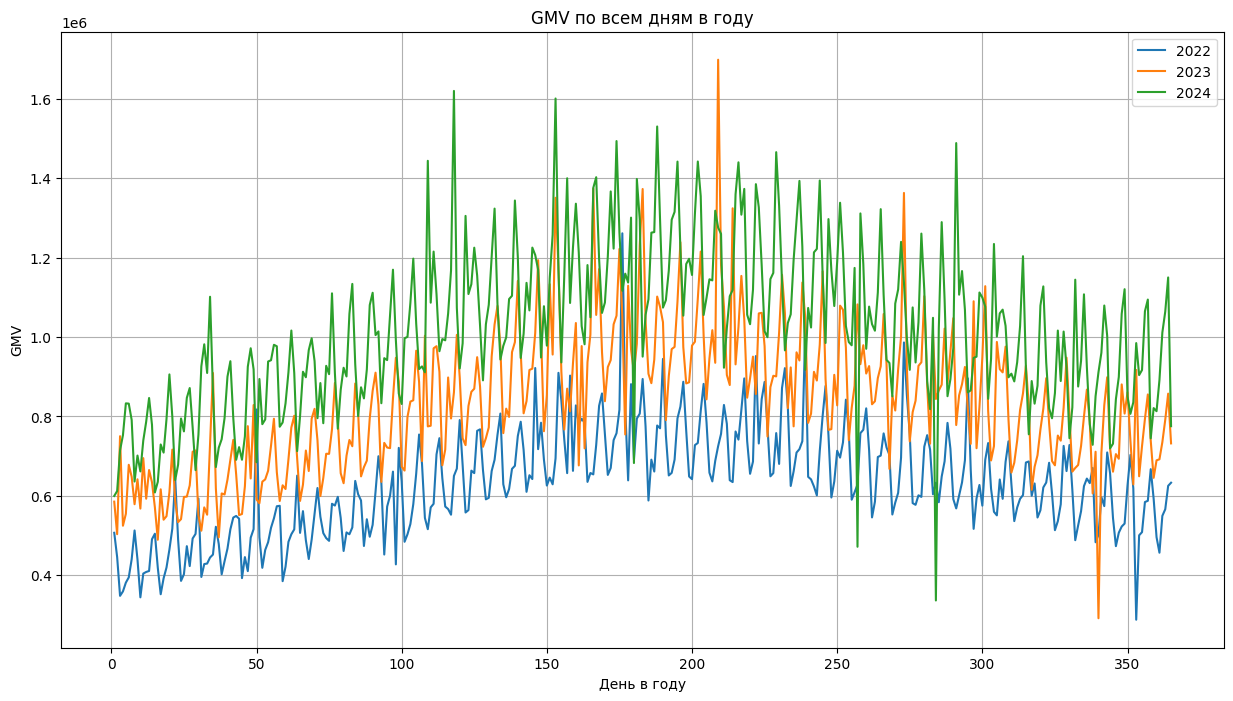

In [143]:
years = (2022, 2023, 2024)

plt.figure(figsize=(15, 8))

for year in years:
    sub = df[df.year == year]
    plt.plot(
        sub.day_of_year,
        sub.gmv,
        label=year
    )

plt.title('GMV по всем дням в году')
plt.xlabel('День в году')
plt.ylabel('GMV')
plt.legend()
plt.grid()
plt.show()

## С учётом крупных промо-акций

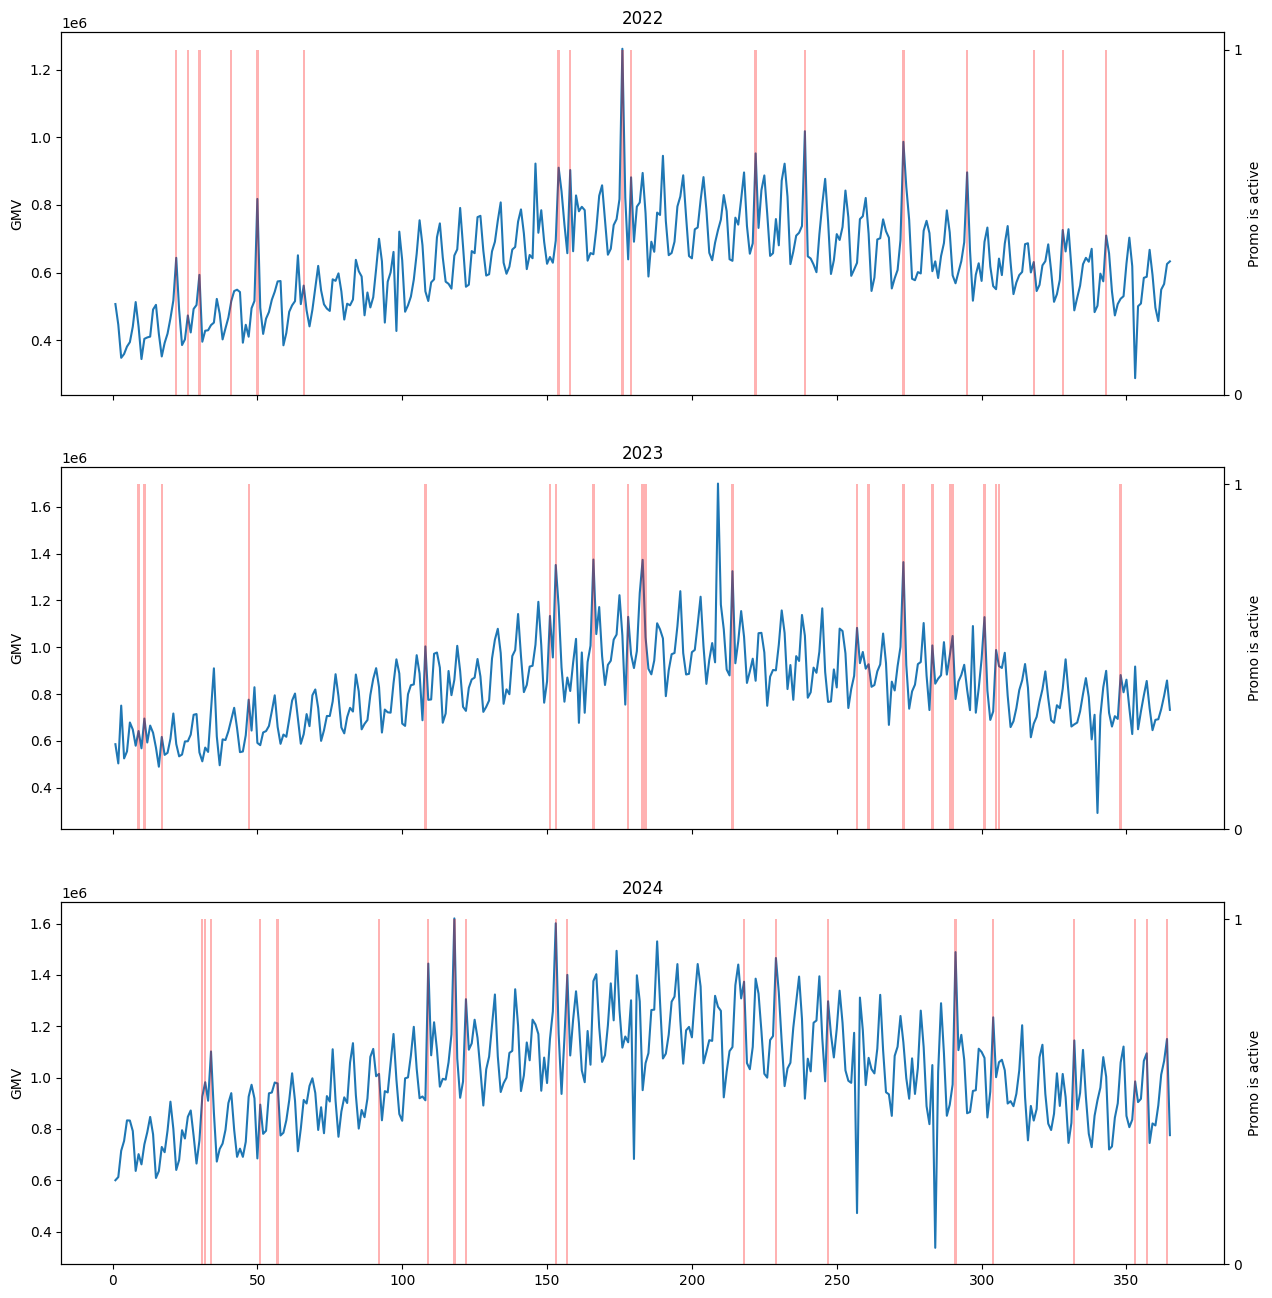

In [144]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.gmv,
    )
    ax.set_title(year)
    ax.set_ylabel('GMV')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

## С учётом масштабов промо

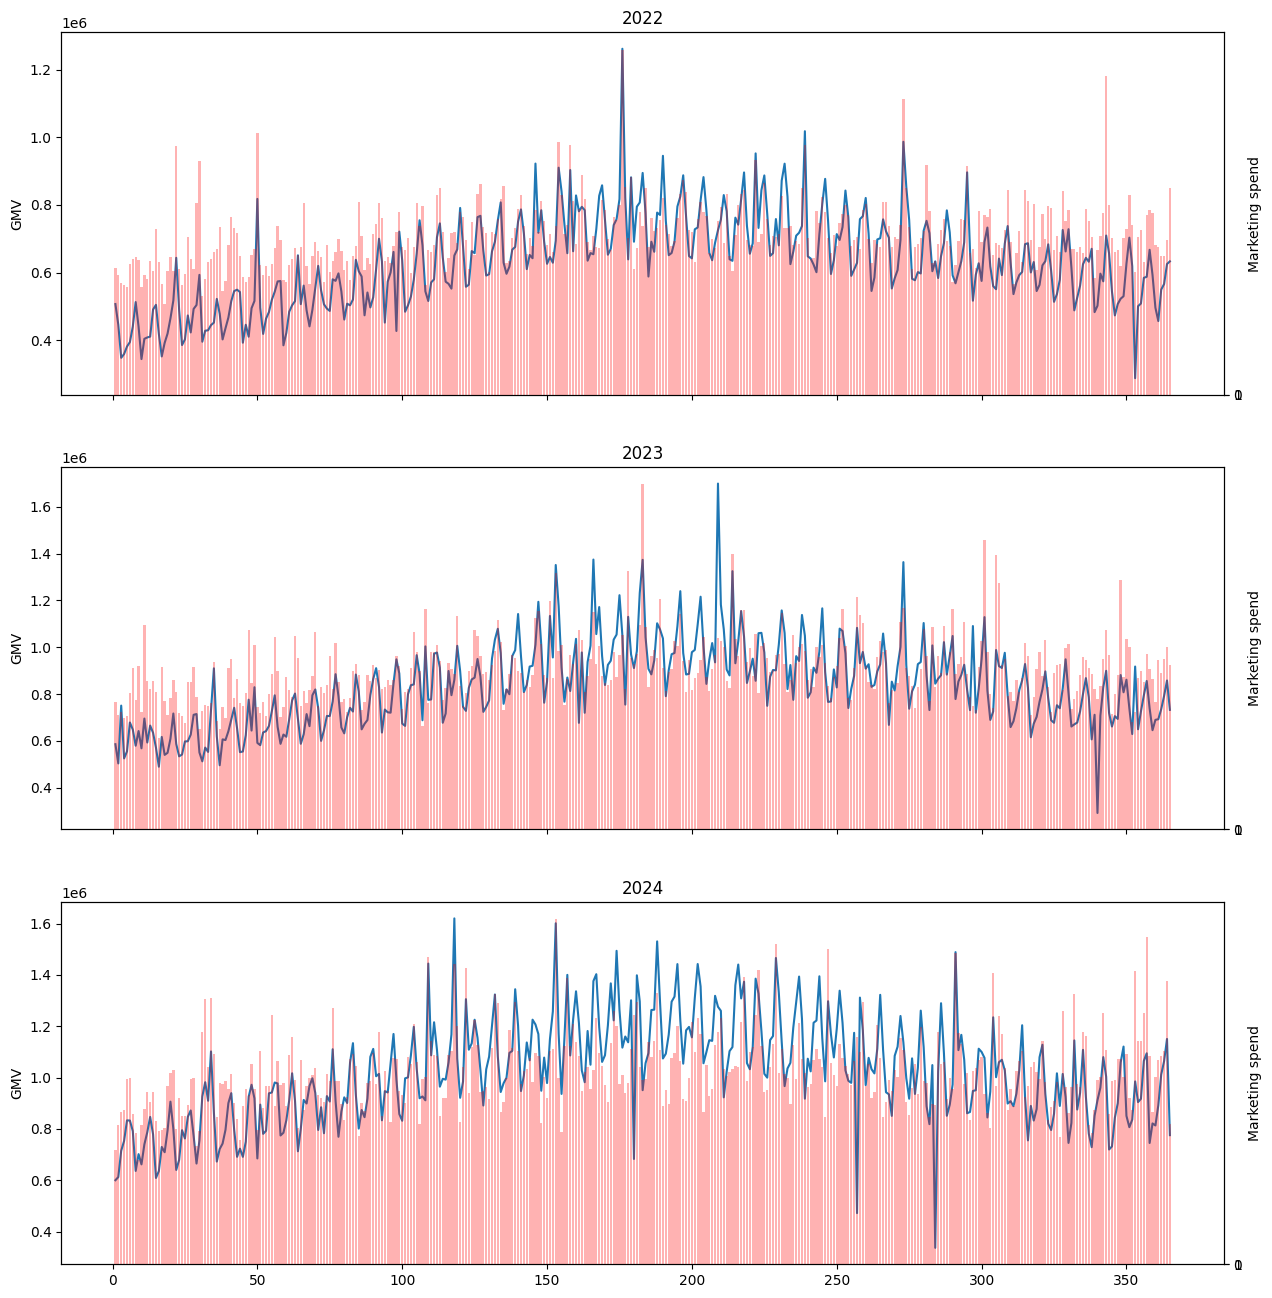

In [145]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.gmv,
    )
    ax.set_title(year)
    ax.set_ylabel('GMV')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.marketing_spend,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Marketing spend')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

## Боксплоты, показывающие сезонность внутри недели

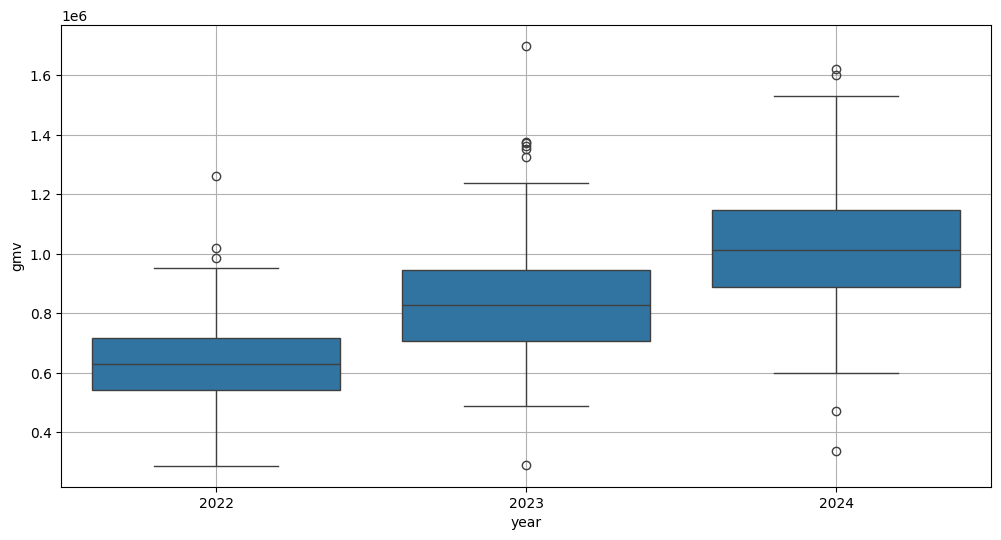

In [146]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x='year',
    y='gmv',
)

plt.grid()

## Есть выбросы, надо проверить, не из-за крупных скидок ли они появились

In [147]:
q1 = df.groupby('year')['gmv'].transform(lambda x: x.quantile(0.25))
q3 = df.groupby('year')['gmv'].transform(lambda x: x.quantile(0.75))
iqr = q3 - q1

df['is_outlier'] = (
    (df['gmv'] < q1 - 1.5 * iqr) |
    (df['gmv'] > q3 + 1.5 * iqr)
)

In [148]:
pd.crosstab(df['is_promo_active'], df['is_outlier'])

is_outlier,False,True
is_promo_active,,
0,1032,4
1,49,10


## Имеется 4 Выброса в дни с неактивным промо. Возможно, была активная маркетинговая компания

In [149]:
df[(df['is_outlier'] == True) & (df['is_promo_active'] == 0)]

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,is_outlier
573,2023-07-28,1698764,5561,195556,49875,0,4,209,30,7,2023,True
704,2023-12-06,291745,2828,95025,33876,0,2,340,49,12,2023,True
986,2024-09-13,471804,4344,175892,60606,0,4,257,37,9,2024,True
1013,2024-10-10,336499,4111,127137,42468,0,3,284,41,10,2024,True


## Последние три выброса не получается обосновать ни маркетингом, ни промо, ни сезонностью (в 2022 и 2023 под конец года были резкие падения gmv, но разброс дат большеват для сезонности, да и в 2024 году выбросы вниз происходят далеко в других датах, так что лучше их, всё-таки, удалить)

## Сумасшедший скачок gmv в 2023 тоже не обоснован выше упомянутыми критериями, от него тоже избавимся

In [150]:
index_to_drop = df[(df['is_outlier'] == True) & (df['is_promo_active'] == 0)].index
df.drop(index=index_to_drop, inplace=True)

## Выбросы в дни с промо-акцией оставим, так как они имеют и приемлимую маректинговую кампанию, и полезную информацию в виде обоснованных скачков

In [168]:
df.loc[
    df['is_promo_active'] == 1,
    'is_outlier'
] = False

## Проанализируем количество заказов

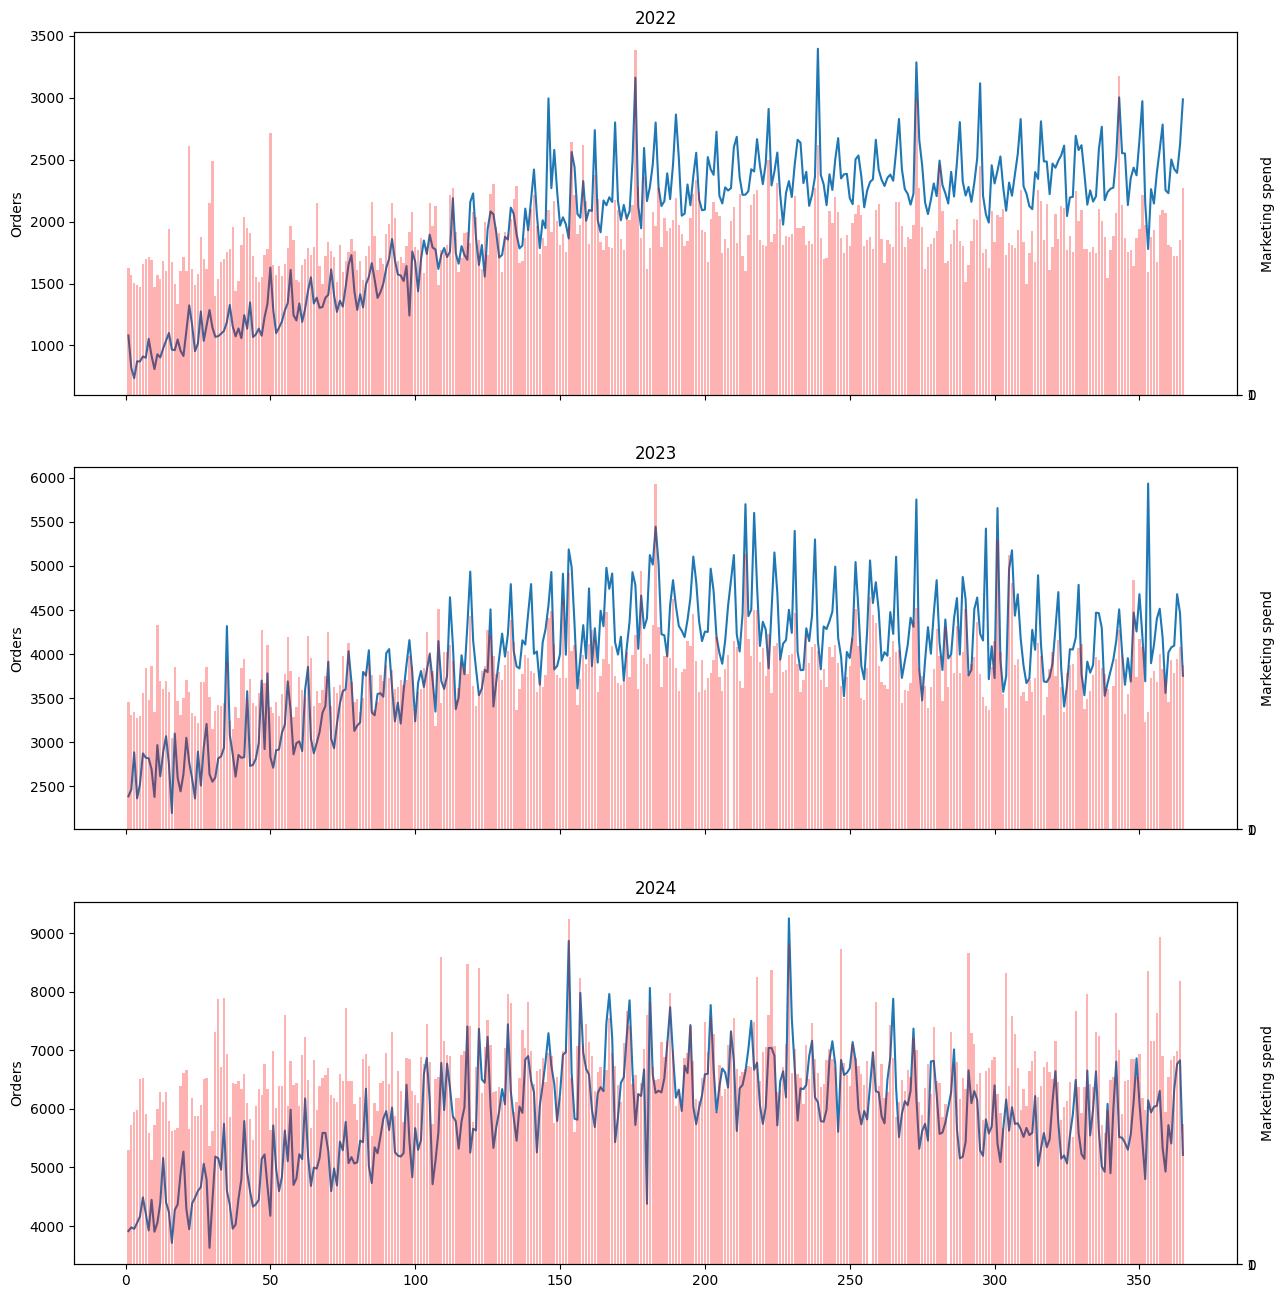

In [152]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.orders,
    )
    ax.set_title(year)
    ax.set_ylabel('Orders')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.marketing_spend,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Marketing spend')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

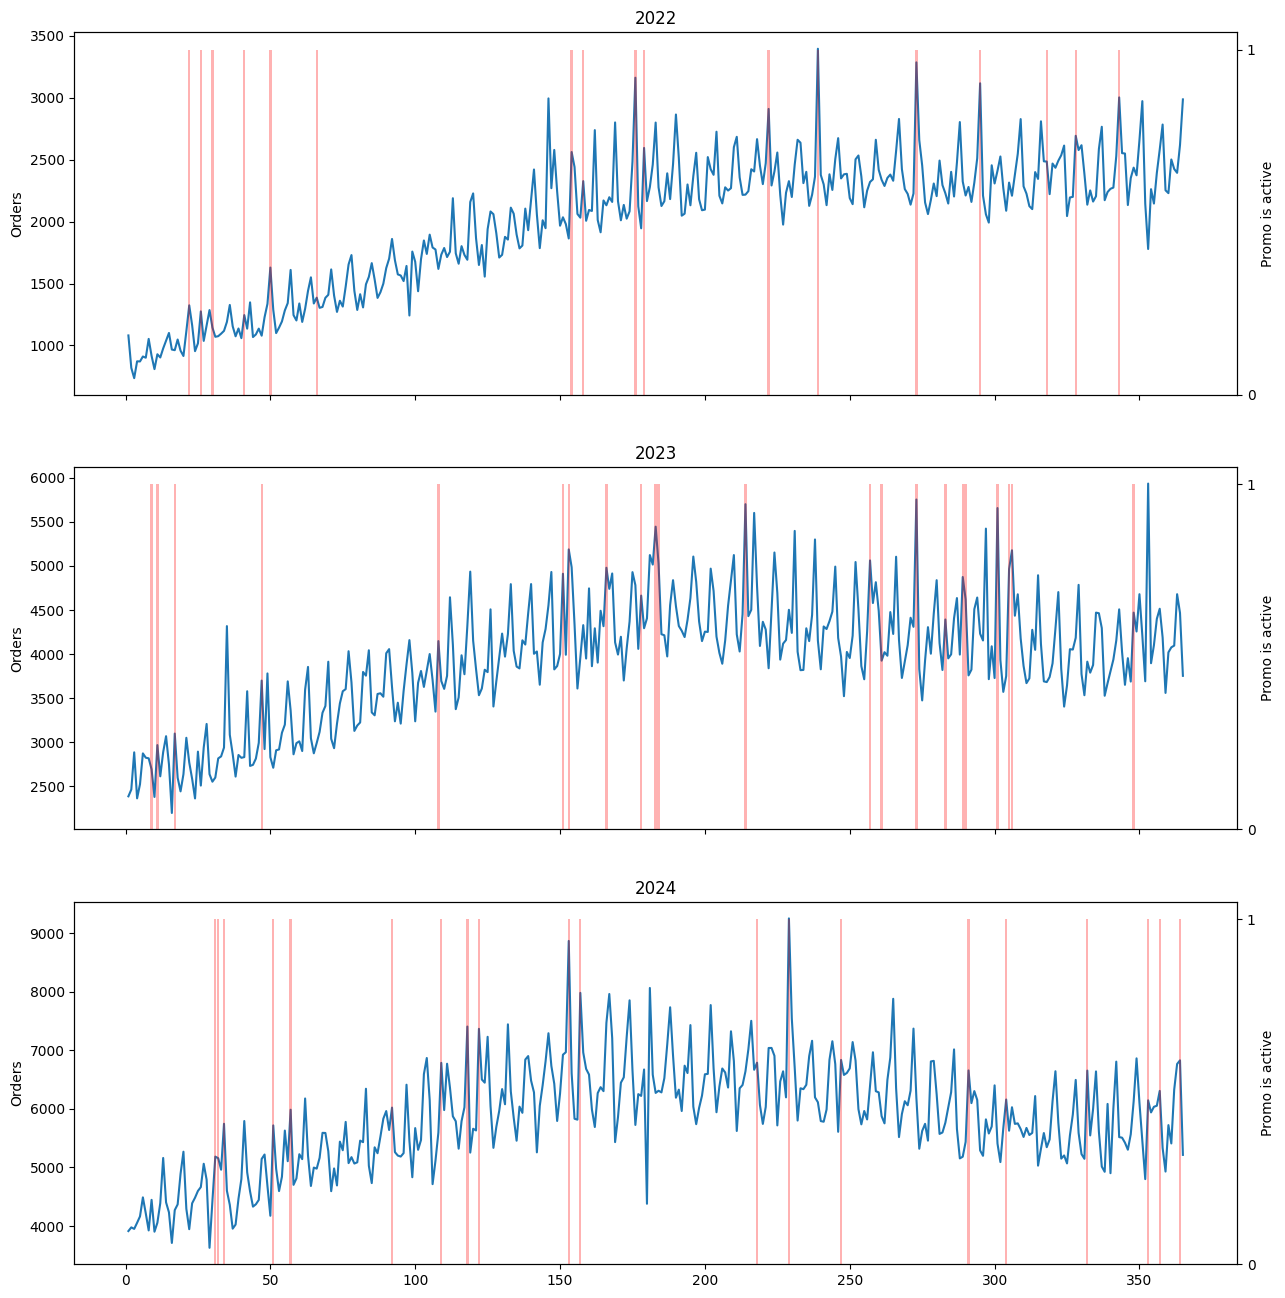

In [172]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.orders,
    )
    ax.set_title(year)
    ax.set_ylabel('Orders')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

## Имеем воходящий тренд, по которому трудно статистическими методами выявлять выбросы, поэтому детрендируем его

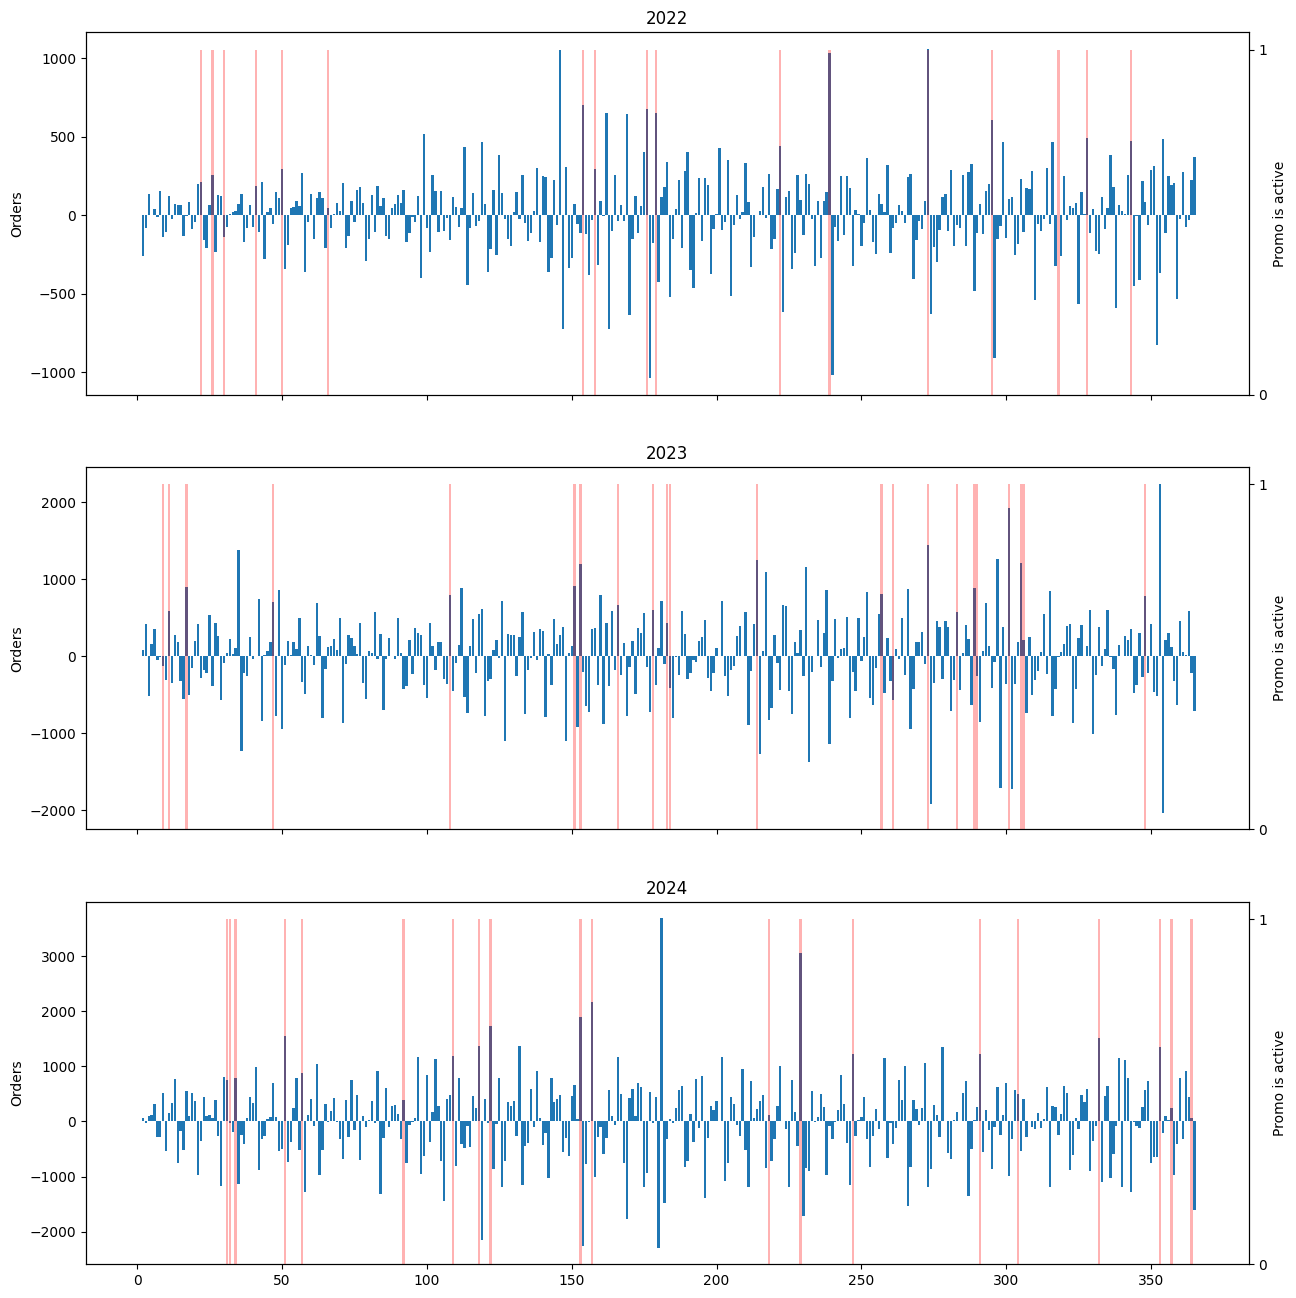

In [173]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.bar(
        sub.day_of_year,
        sub.orders.diff(),
    )
    ax.set_title(year)
    ax.set_ylabel('Orders')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

In [174]:
detrended = df.copy()
detrended['orders'] = detrended['orders'].diff()

q1 = detrended.groupby('year')['orders'].transform(lambda x: x.quantile(0.25))
q3 = detrended.groupby('year')['orders'].transform(lambda x: x.quantile(0.75))
iqr = q3 - q1

df['is_outlier_orders'] = (
    (detrended['orders'] < q1 - 1.5 * iqr) |
    (detrended['orders'] > q3 + 1.5 * iqr)
)

pd.crosstab(df['is_promo_active'], df['is_outlier_orders'])

# df[(df['is_outlier_orders'] == True) & (df['is_promo_active'] == 0)]
# df[(df['is_outlier_orders'] == True) & (df['is_promo_active'] == 1)]

# index_to_drop = df[(df['is_outlier_orders'] == True) & (df['is_promo_active'] == 0)].index
# df.drop(index=index_to_drop, inplace=True)

is_outlier_orders,False,True
is_promo_active,,
0,1005,27
1,47,12


In [175]:
index_to_drop = df[(df['is_outlier_orders'] == True) & (df['is_promo_active'] == 0)].index
# df.drop(index_to_drop)

df[(df['is_outlier_orders'] == True) & (df['is_promo_active'] == 0)]

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,is_outlier,is_outlier_orders
145,2022-05-26,922128,2995,89141,36654,0,3,146,21,5,2022,False,True
146,2022-05-27,717672,2270,79117,32410,0,4,147,21,5,2022,False,True
161,2022-06-11,794419,2739,90916,43629,0,5,162,23,6,2022,False,True
162,2022-06-12,784483,2013,79154,38941,0,6,163,23,6,2022,False,True
168,2022-06-18,857984,2801,82102,38738,0,5,169,24,6,2022,False,True
169,2022-06-19,755958,2165,88582,36629,0,6,170,24,6,2022,False,True
176,2022-06-26,821679,2124,85652,41226,0,6,177,25,6,2022,False,True
222,2022-08-11,731948,2292,67385,30256,0,3,223,32,8,2022,False,True
239,2022-08-28,647956,2377,82289,31092,0,6,240,34,8,2022,False,True
273,2022-10-01,854081,2658,109637,41066,0,5,274,39,10,2022,False,True


## Если удалить выбросы, произошедшие в дни без промо-акций, то получим такую картину

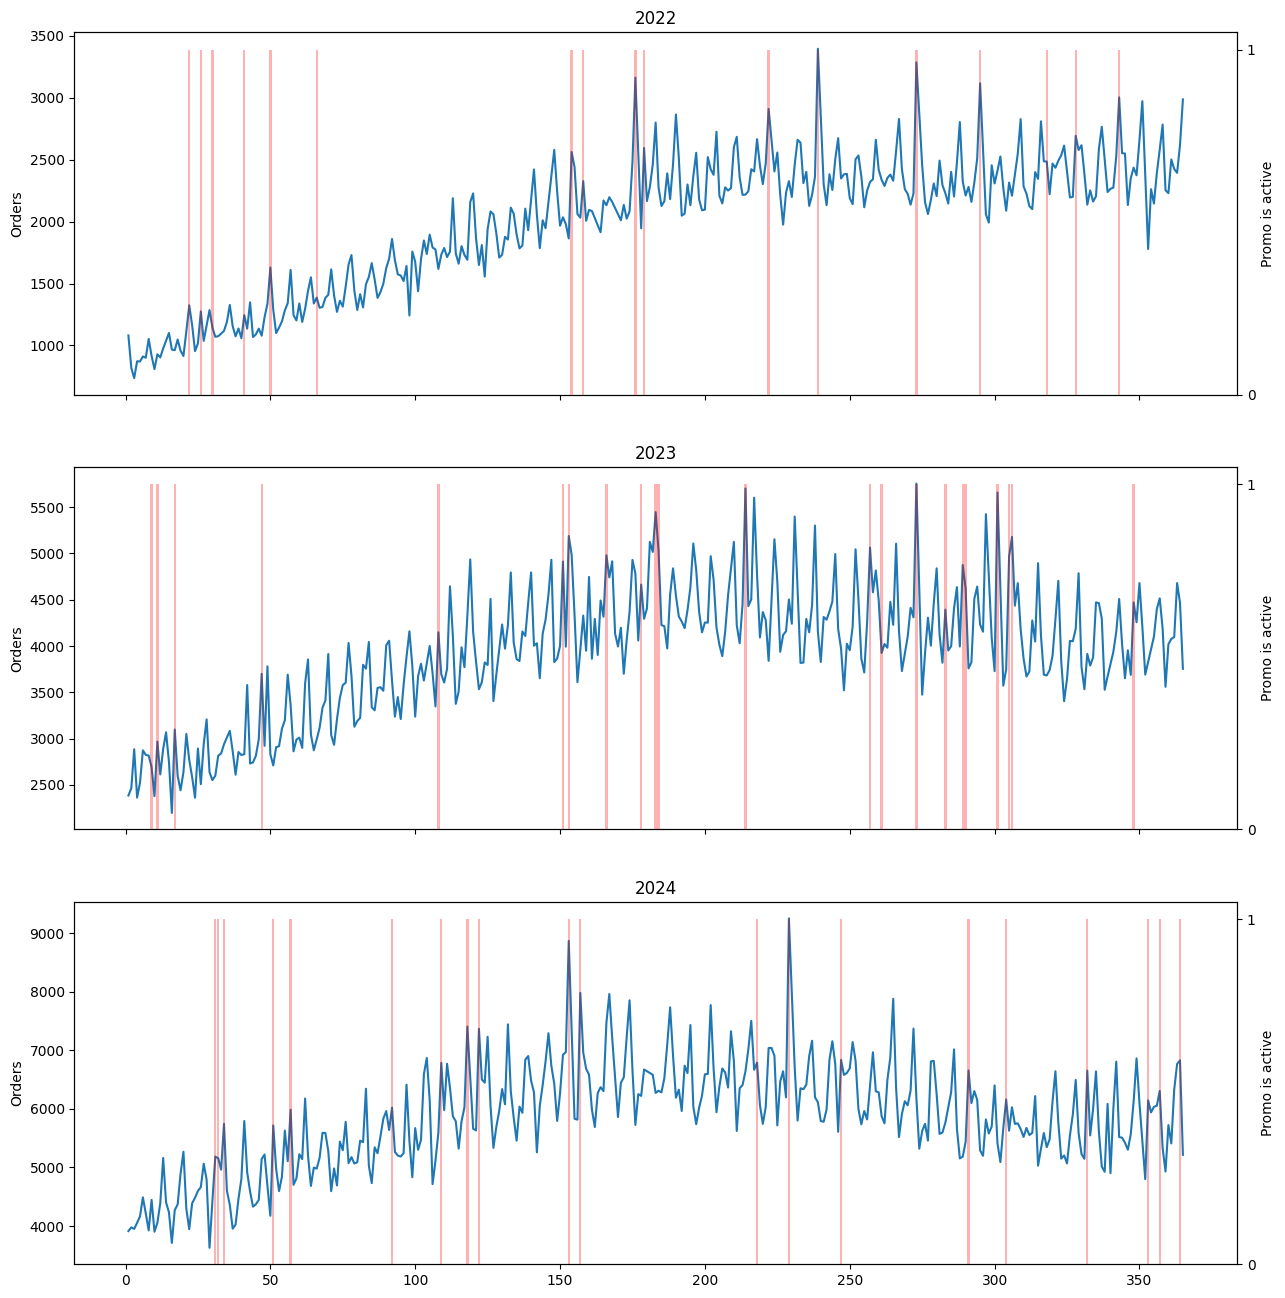

In [176]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

df_cleared = df.drop(index_to_drop)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df_cleared[(df_cleared.year == year)]
    
    ax.plot(
        sub.day_of_year,
        sub.orders,
    )
    ax.set_title(year)
    ax.set_ylabel('Orders')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

In [177]:
df.drop(index_to_drop, inplace=True)